# 1.0 Initial Data Exploration

#### Load in Spotify client_id and client_secret

In [21]:
import os
from dotenv import load_dotenv, dotenv_values
import matplotlib.pyplot as plt
from utils import tokenize_song_by_stanza
import random

# Load existing environment variables
load_dotenv()

client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')

### Read Spotify Dataset

In [22]:
# Read the data
import pandas as pd
df = pd.read_csv('../data/raw/spotify_millsongdata.csv')
# Add genre_list column
df['genre_list'] = [[]] * len(df)
df.head()

,artist,song,link,text,genre_list
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA...",[]
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen...",[]
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...,[]
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...,[]
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...,[]


#### Get genres of artist from Spotify API and add to each song of artist

In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genre(client_id, client_secret, artist_name):
    # Set up Spotify API credentials
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    # Search for the artist
    results = sp.search(q=artist_name, type='artist', limit=1)

    # Check if there are search results
    if results['artists']['items']:
        artist_genres = results['artists']['items'][0]['genres']
        return artist_genres
    else:
        return []


In [24]:
artist_set = df['artist'].unique()

for artist in artist_set:
    artist_genres = get_artist_genre(client_id, client_secret, artist)
    rows = df.loc[df['artist'] == artist]
    for index, row in rows.iterrows():
        df.at[index, 'genre_list'] = artist_genres

In [25]:
empty_genres = 0
for index, row in df.iterrows():
  if row['genre_list'] == []:
    empty_genres += 1
print('There are', empty_genres, 'songs with empty genre lists.')
  

There are 1144 songs with empty genre lists.


#### Remove all songs with no genres

In [26]:
df = df[df['genre_list'].apply(lambda x: len(x) > 0)]
empty_genres = 0
for index, row in df.iterrows():
  if row['genre_list'] == []:
    empty_genres += 1
print('There are', empty_genres, 'songs with empty genre lists.')

There are 0 songs with empty genre lists.


#### Remove songs that are not in English

In [27]:
import langid

def detect_language(text):
    # Returns a tuple containing the language code and the confidence
    lang, confidence = langid.classify(text)
    return lang == 'en'

In [28]:
print('There are', len(df), 'songs in the dataset.')
df = df[df['text'].apply(lambda x: detect_language(x))]
print('There are', len(df), 'songs in the dataset after removing non-English songs.')


There are 56506 songs in the dataset.
There are 56067 songs in the dataset after removing non-English songs.


#### Group similar genres together

In [29]:
def genre_list_to_genre(genre_list):
  for genre in genre_list:
    if 'rock' in genre or 'metal' in genre or 'punk' in genre:
      return 'rock'
    elif 'hip hop' in genre or 'rap' in genre:
      return 'hip_hop'
    elif 'indie' in genre or 'alternative' in genre or 'folk' in genre:
      return 'indie'
    elif 'jazz' in genre or 'blues' in genre:
      return 'jazz'
    elif 'country' in genre or 'bluegrass' in genre:
      return 'country'
    elif 'pop' in genre:
      return 'pop'
  return ''

In [30]:
df['genre'] = ''

In [31]:
for index, row in df.iterrows():
  genre_list = row['genre_list']
  df.at[index, 'genre'] = genre_list_to_genre(genre_list)

#### Remove songs that are not part of six main genres

In [32]:
count = 0 
for index, row in df.iterrows():
  if row['genre'] == '':
    count += 1
print('Theres', count, 'songs with uncommon genres.')



Theres 5485 songs with uncommon genres.


In [33]:
for index, row in df.iterrows():
  if row['genre'] == '':
    df.drop(index, inplace=True)

# Save the Data to CSV

In [34]:
df.to_csv('../data/processed/processed_data.csv', index=False)

## Save Stanzas to txt file

In [35]:
N_GRAM = 5

In [36]:
data_lyrics = df['text'].tolist()
data_genre = df['genre'].tolist()
data = []
for song, genre in zip(data_lyrics, data_genre):
  lines = tokenize_song_by_stanza(song, ngram=N_GRAM)
  for line in lines:
    line.insert(0, genre)
  data.extend(lines)
print(data[0])
random.shuffle(data)
# Writing to a TXT file
txt_filename = '../data/processed/stanzas.txt'
with open(txt_filename, 'w', encoding='utf-8') as txtfile:
    for line in data:
        txtfile.write('\t'.join(map(str, line)) + '\n')

['pop', '<s>', '<s>', '<s>', 'look', 'at', 'her', 'face', ',', 'it', "'s", 'a', 'wonderful', 'face', 'newlinebreak', 'and', 'it', 'means', 'something', 'special', 'to', 'me', 'newlinebreak', 'look', 'at', 'the', 'way', 'that', 'she', 'smiles', 'when', 'she', 'sees', 'me', 'newlinebreak', 'how', 'lucky', 'can', 'one', 'fellow', 'be', '?', 'newlinebreak', 'newlinebreak', 'she', "'s", 'just', 'my', 'kind', 'of', 'girl', ',', 'she', 'makes', 'me', 'feel', 'fine', 'newlinebreak', 'who', 'could', 'ever', 'believe', 'that', 'she', 'could', 'be', 'mine', '?', 'newlinebreak', 'she', "'s", 'just', 'my', 'kind', 'of', 'girl', ',', 'without', 'her', 'i', "'m", 'blue', 'newlinebreak', 'and', 'if', 'she', 'ever', 'leaves', 'me', 'what', 'could', 'i', 'do', ',', 'what', 'could', 'i', 'do', '?', 'newlinebreak', 'newlinebreak', 'and', 'when', 'we', 'go', 'for', 'a', 'walk', 'in', 'the', 'park', 'newlinebreak', 'and', 'she', 'holds', 'me', 'and', 'squeezes', 'my', 'hand', 'newlinebreak', 'we', "'ll", 'g

# Graphs for Report

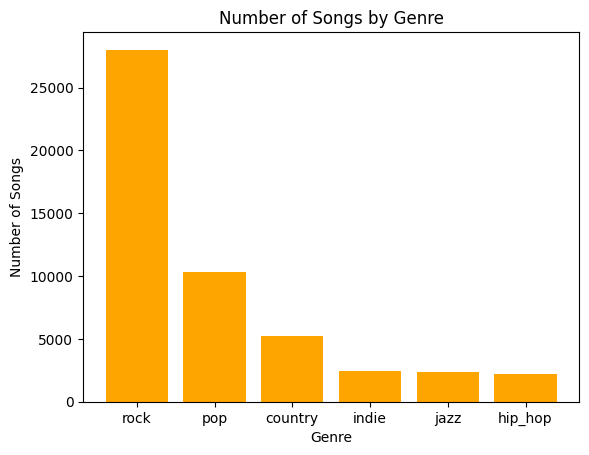

In [37]:
genre_counts = df['genre'].value_counts()
plt.bar(genre_counts.index, genre_counts.values, color='orange')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Number of Songs by Genre')
plt.show()